In [1]:
import numpy as np
import pickle
import random
import torch
from nomaenv import NomaEnv
import matplotlib.pyplot as plt

In [2]:
#from algorithms.noma_ppo import *
from algorithms.baselines import *

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [4]:
k = 20
deadlines = np.array([5 for _ in range(k)])
offsets = None
arrival_probs = None
period = None

scores = []
distances = [65, 100, 150, 200, 300]
for d in distances:
    scores_seed = []
    for seed in range(3):
        print(d)
        print(seed)
        env = NomaEnv(k,
                      deadlines,
                      lbda=1/9.3,
                      period=period,
                      arrival_probs=arrival_probs,
                      offsets=offsets,
                      episode_length=200,
                      max_simultaneous_devices=3,
                      traffic_model='aperiodic',
                      channel_model='interference',
                      distances=d,
                      path_loss=True,
                      shadowing=True,
                      fast_fading=True,
                      verbose=False
                     )
        edf = EarliestDeadlineFirstScheduler(env, verbose=True)
        sc = edf.run(200)
        scores_seed.append(sc)
    print(scores_seed)
    scores.append(scores_seed)

65
0
Number of received packets: 81618.0
65
1
Number of received packets: 81032.0
65
2
Number of received packets: 81447.0
[1.0, 1.0, 1.0]
100
0
Number of received packets: 81677.0
100
1
Number of received packets: 81543.0
100
2
Number of received packets: 81359.0
[1.0, 0.9999754730632917, 1.0]
150
0
Number of received packets: 81811.0
150
1
Number of received packets: 81506.0
150
2
Number of received packets: 81572.0
[0.9953918177262226, 0.9802959291340515, 1.0]
200
0
Number of received packets: 81284.0
200
1
Number of received packets: 81843.0
200
2
Number of received packets: 81734.0
[0.9671645096205895, 0.9212638832887358, 0.9493478846012675]
300
0
Number of received packets: 81441.0
300
1
Number of received packets: 81614.0
300
2
Number of received packets: 81466.0
[0.8809936027308113, 0.8881564437473963, 0.9465789409078634]


In [5]:
np.array(scores)

array([[1.        , 1.        , 1.        ],
       [1.        , 0.99997547, 1.        ],
       [0.99539182, 0.98029593, 1.        ],
       [0.96716451, 0.92126388, 0.94934788],
       [0.8809936 , 0.88815644, 0.94657894]])

In [6]:
results = {'distances': distances,
          'scores': np.array(scores)
          }

In [7]:
pickle.dump(results, open('results/edf_aperiodic_interference_k20_distances.p', 'wb'))

### Experiment: epsilon function of avg SNR

In [4]:
k = 4
deadlines = np.array([5 for _ in range(k)])
offsets = None
arrival_probs = None
period = None


env = NomaEnv(k,
              deadlines,
              lbda=1/9.3,
              period=period,
              arrival_probs=arrival_probs,
              offsets=offsets,
              episode_length=200,
              max_simultaneous_devices=3,
              traffic_model='aperiodic',
              channel_model='interference',
              distances=150,
              path_loss=False,
              shadowing=False,
              fast_fading=False,
              verbose=False
             )

In [5]:
# Without FF
low = -7
avg_snrs_db = np.arange(low, -3, 0.1)
avg_snr = 10**(avg_snrs_db / 10)
eps = env.compute_epsilon(avg_snr)


In [ ]:
plt.plot(avg_snrs_db, eps, label='epsilon, no FF')
plt.xlabel("avg SNR (dB)")
plt.ylabel("epsilon")
plt.legend(fontsize=13)

In [104]:
# With FF
avg_snrs_db = np.arange(-7, -3, 0.1)
avg_snr = 10**(avg_snrs_db / 10)

h_upper = 2 + 1
h_lower = 2 - 1

eps = env.compute_epsilon(avg_snr)
eps_ff = env.compute_epsilon(avg_snr*2)
eps_upper = env.compute_epsilon(avg_snr*2.75)
eps_lower = env.compute_epsilon(avg_snr*1.15)

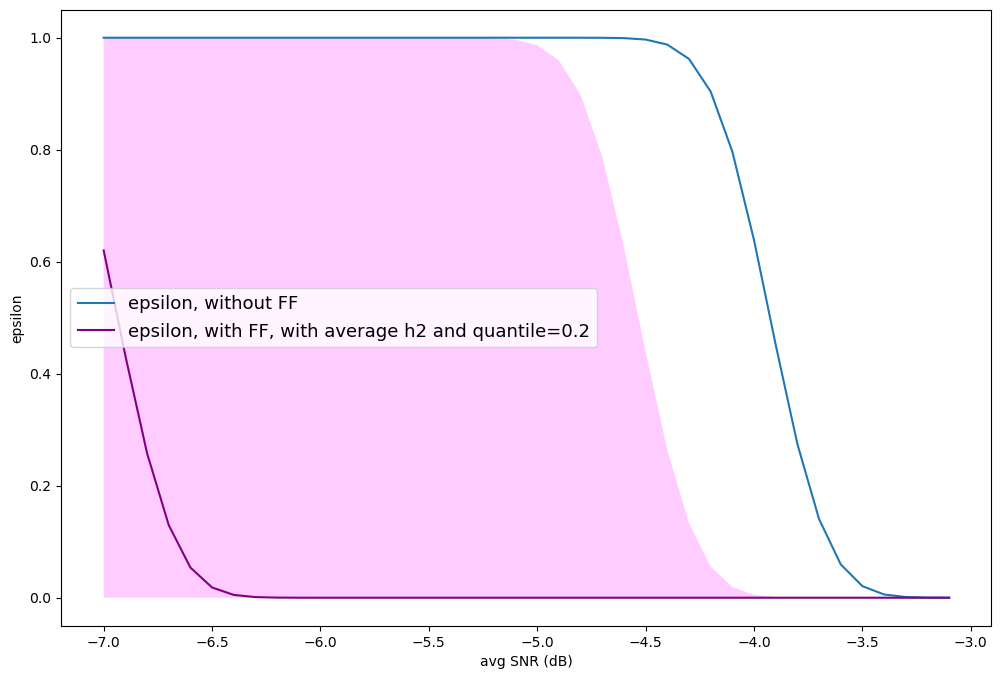

In [106]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

ax.plot(avg_snrs_db, eps, label='epsilon, without FF')
ax.plot(avg_snrs_db, eps_ff, color='purple', label='epsilon, with FF, with average h2 and quantile=0.2')
ax.fill_between(avg_snrs_db,
               eps_upper,
               eps_lower,
               facecolor='magenta',
               alpha=0.2)


plt.xlabel("avg SNR (dB)")
plt.ylabel("epsilon")
plt.legend(fontsize=13)

In [ ]:
h = np.random.multivariate_normal(np.array([0, 0]), 0.5 * np.diag([1, 1]), size=(5, env.nt))
complex_h = np.matrix(h[:, :, 0] + 1j*(h[:, :, 1]))

In [9]:
h_coeffs = complex_h.dot(complex_h.getH())

In [10]:
h_coeffs

matrix([[ 1.97434938+0.j        , -1.85216814+0.9265355j ,
          0.12255576-1.14066192j,  0.88002314-1.04014347j,
         -1.27137341+2.37153509j],
        [-1.85216814-0.9265355j ,  5.92277706+0.j        ,
          0.84240223-0.44834825j, -1.23808348+1.0497725j ,
         -0.71263043-1.89502328j],
        [ 0.12255576+1.14066192j,  0.84240223+0.44834825j,
          3.33138848+0.j        ,  1.04588196+0.91300962j,
         -2.54273386-1.06447226j],
        [ 0.88002314+1.04014347j, -1.23808348-1.0497725j ,
          1.04588196-0.91300962j,  2.89580756+0.j        ,
         -2.29977776+2.18297563j],
        [-1.27137341-2.37153509j, -0.71263043+1.89502328j,
         -2.54273386+1.06447226j, -2.29977776-2.18297563j,
          7.46535152+0.j        ]])

In [11]:
h2 = np.absolute(np.diag(h_coeffs))

In [12]:
h2

array([1.97434938, 5.92277706, 3.33138848, 2.89580756, 7.46535152])

In [35]:
np.sum(np.array(np.absolute(complex_h[0]))**2)

1.9743493756775208

In [23]:
np.absolute(h_coeffs[0,1])

2.070988853615461

In [21]:
np.array(np.absolute(h_coeffs[0,np.array([1,2])]))**2

array([[4.28899483, 1.31612954]])

In [29]:
np.array(np.absolute(h_coeff[3, np.array([2, 4])]))

array([[1.79525536, 0.7657036 ]])

In [9]:
np.sum(np.array(np.absolute(complex_h[0]))**2)

2.570826392762963

In [10]:
complex_h[0].dot(complex_h[1].getH())

matrix([[-0.29215231+2.30992881j]])

In [17]:
np.absolute(np.diag(complex_h.dot(complex_h.getH())))

array([2.57082639, 3.76594007, 6.22066223, 2.20460225, 1.72567096,
       3.1873862 , 5.00732042, 3.8500176 , 4.84088892, 7.59678158,
       2.80266531, 2.10215704, 2.80076747, 1.946094  , 1.58155067,
       3.24750738, 5.56162499, 3.63683533, 2.46466598, 4.23887194])

In [18]:
np.linalg.norm(np.diag(complex_h.dot(complex_h.getH())), -1)

0.14925865676413264

In [15]:
np.diag(complex_h.dot(complex_h.getH()))

array([2.57082639+0.j, 3.76594007+0.j, 6.22066223+0.j, 2.20460225+0.j,
       1.72567096+0.j, 3.1873862 +0.j, 5.00732042+0.j, 3.8500176 +0.j,
       4.84088892+0.j, 7.59678158+0.j, 2.80266531+0.j, 2.10215704+0.j,
       2.80076747+0.j, 1.946094  +0.j, 1.58155067+0.j, 3.24750738+0.j,
       5.56162499+0.j, 3.63683533+0.j, 2.46466598+0.j, 4.23887194+0.j])

In [10]:
complex_h[0,0]

(0.6251536967836954-0.672234955666844j)

In [11]:
np.absolute(complex_h[0,0])

0.9179961765839356

In [13]:
np.sqrt(0.6251536967836954**2 + 0.672234955666844**2)

0.9179961765839356

In [62]:
z = [np.random.normal(0, 0.5, size=(100000))**2 for _ in range(8)]

In [63]:
np.stack(z).sum(0).mean()

1.9997687973265734

In [64]:
np.stack(z).sum(0).var()

0.9971920835052542

In [89]:
np.percentile(np.stack(z).sum(0), 80)

2.754892569976835

In [99]:
np.percentile(np.stack(z).sum(0), 50)

1.8366496429062615